In [109]:
## Import

import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import statistics as stat
az.style.use('arviz-darkgrid')

*References*

References: I referenced Geoff Hansen's (classmate) code, the Hierarchical Model Assignment, the Model Selection Assignment, the IrisLogReg Assignment, Wikipedia, Office Hours, and Stack Overflow in the completion of this homework. 

For Problem 1, I figured out part a through office hours on 31 October. I am still struggling with this theoretical concept.

For Problem 2, I referenced Geoff's code for plot creation (in addition to this website: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html), and to work through sampling logic. I did attempt to create a modified/improved version of his attempt, but his code structure was heavily referenced, so it will likely look similar (X1/X2 sample arrays, etc.). I made sure to understand what was happening theoretically before referencing this material. All other help was derived from assignment starter code.

For Problems 3 and 5, I referenced Geoff's code to discover the GLM model function, a way to normalize the data through a definition, and how to plot kernel density functions. All other help was derived from assignment starter code.

For Problem 4, I referenced Geoff's code to discover that a Deterministic distribution fed into the Binomial distribution for several models. This was mentioned in a class that I could not attend. His code also helped me figure out the pm.invlogit() function. All other help was derived from assignment starter code.


*Problem 3 Write Up*

All of my variables converged after conducting NUTS MCMC sampling. Based on the results, Age had the largest influence of all other predictors on the CHD response variable. However, the 94% credible interval was relatively large for this predictor, casting some question over the confidence with which we can make this assessment.

*Problem 5 Write Up*

Based on the WAIC comparison, we should adopt Model 1 because it has the lowest WAIC.

In [110]:
## Read in data

df=pd.read_csv("CHDdata.csv")
df.head()
stat.mean(df.tobacco)
df.famhist=df.famhist.replace({"Present":1, "Absent":0})
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [111]:
## Normalize and make famhist a binary
results=df.chd

def normalize(df):
    
    for column in df.columns:
        mean=stat.mean(df[column])
        sd=stat.pstdev(df[column])
        df[column]=df[column]-mean
        df[column]=df[column]/sd
        
    return df
df_norm=df.drop(["chd"], axis=1)
df_norm=normalize(df_norm)
df_norm["chd"]=results
df_norm.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.058564,1.823073,0.478412,-0.295503,1.185854,-0.418470,-0.176786,3.277738,0.629336,1
1,0.277089,-0.790237,-0.159680,0.412140,-0.843274,0.193344,0.671373,-0.612745,1.383115,1
2,-0.992806,-0.774980,-0.609245,0.884332,1.185854,-0.112563,0.735519,-0.541183,0.218184,0
3,1.546985,0.842264,0.807126,1.624141,1.185854,-0.214532,1.412621,0.295062,1.040488,1
4,-0.211332,2.171805,-0.599577,0.305351,1.185854,0.703189,-0.012856,1.647775,0.423760,1


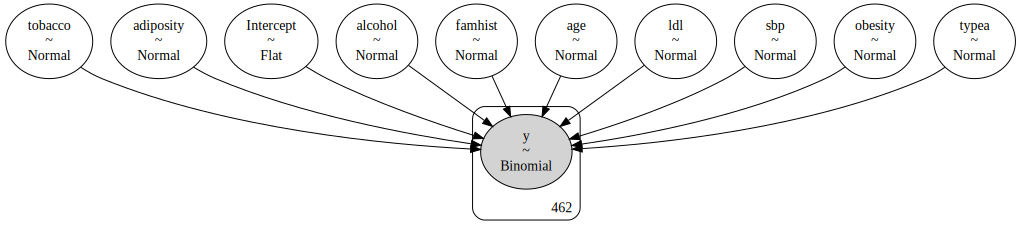

In [112]:
## Create logistic regression model

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula = 'chd ~ sbp + tobacco + ldl + adiposity + famhist + typea + obesity + alcohol + age', 
                            data = df_norm, 
                            family = pm.glm.families.Binomial())
pm.model_to_graphviz(model)

In [113]:
## Trace

with model:
    trace = pm.sample(1000)
    model_idata = az.from_pymc3(trace)
az.summary(model_idata, round_to=2)

<ipython-input-113-a611b9d229f6>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [age, alcohol, obesity, typea, famhist, adiposity, ldl, tobacco, sbp, Intercept]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 865 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.90,0.12,-1.11,-0.65,0.0,0.0,4041.94,2401.41,1.0
sbp,0.14,0.12,-0.09,0.35,0.0,0.0,4730.86,2164.06,1.0
tobacco,0.38,0.13,0.15,0.61,0.0,0.0,4378.80,2316.12,1.0
ldl,0.37,0.12,0.14,0.60,0.0,0.0,4081.24,2116.23,1.0
adiposity,0.15,0.23,-0.30,0.58,0.0,0.0,2850.00,2229.98,1.0
famhist,0.47,0.11,0.26,0.68,0.0,0.0,4633.07,2076.87,1.0
typea,0.40,0.12,0.18,0.63,0.0,0.0,4948.72,2307.48,1.0
obesity,-0.28,0.19,-0.67,0.04,0.0,0.0,3082.93,2475.25,1.0
alcohol,0.00,0.11,-0.20,0.22,0.0,0.0,4661.44,2465.17,1.0
age,0.68,0.18,0.33,1.00,0.0,0.0,3209.79,2529.01,1.0


<ipython-input-114-1e975ac49da0>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


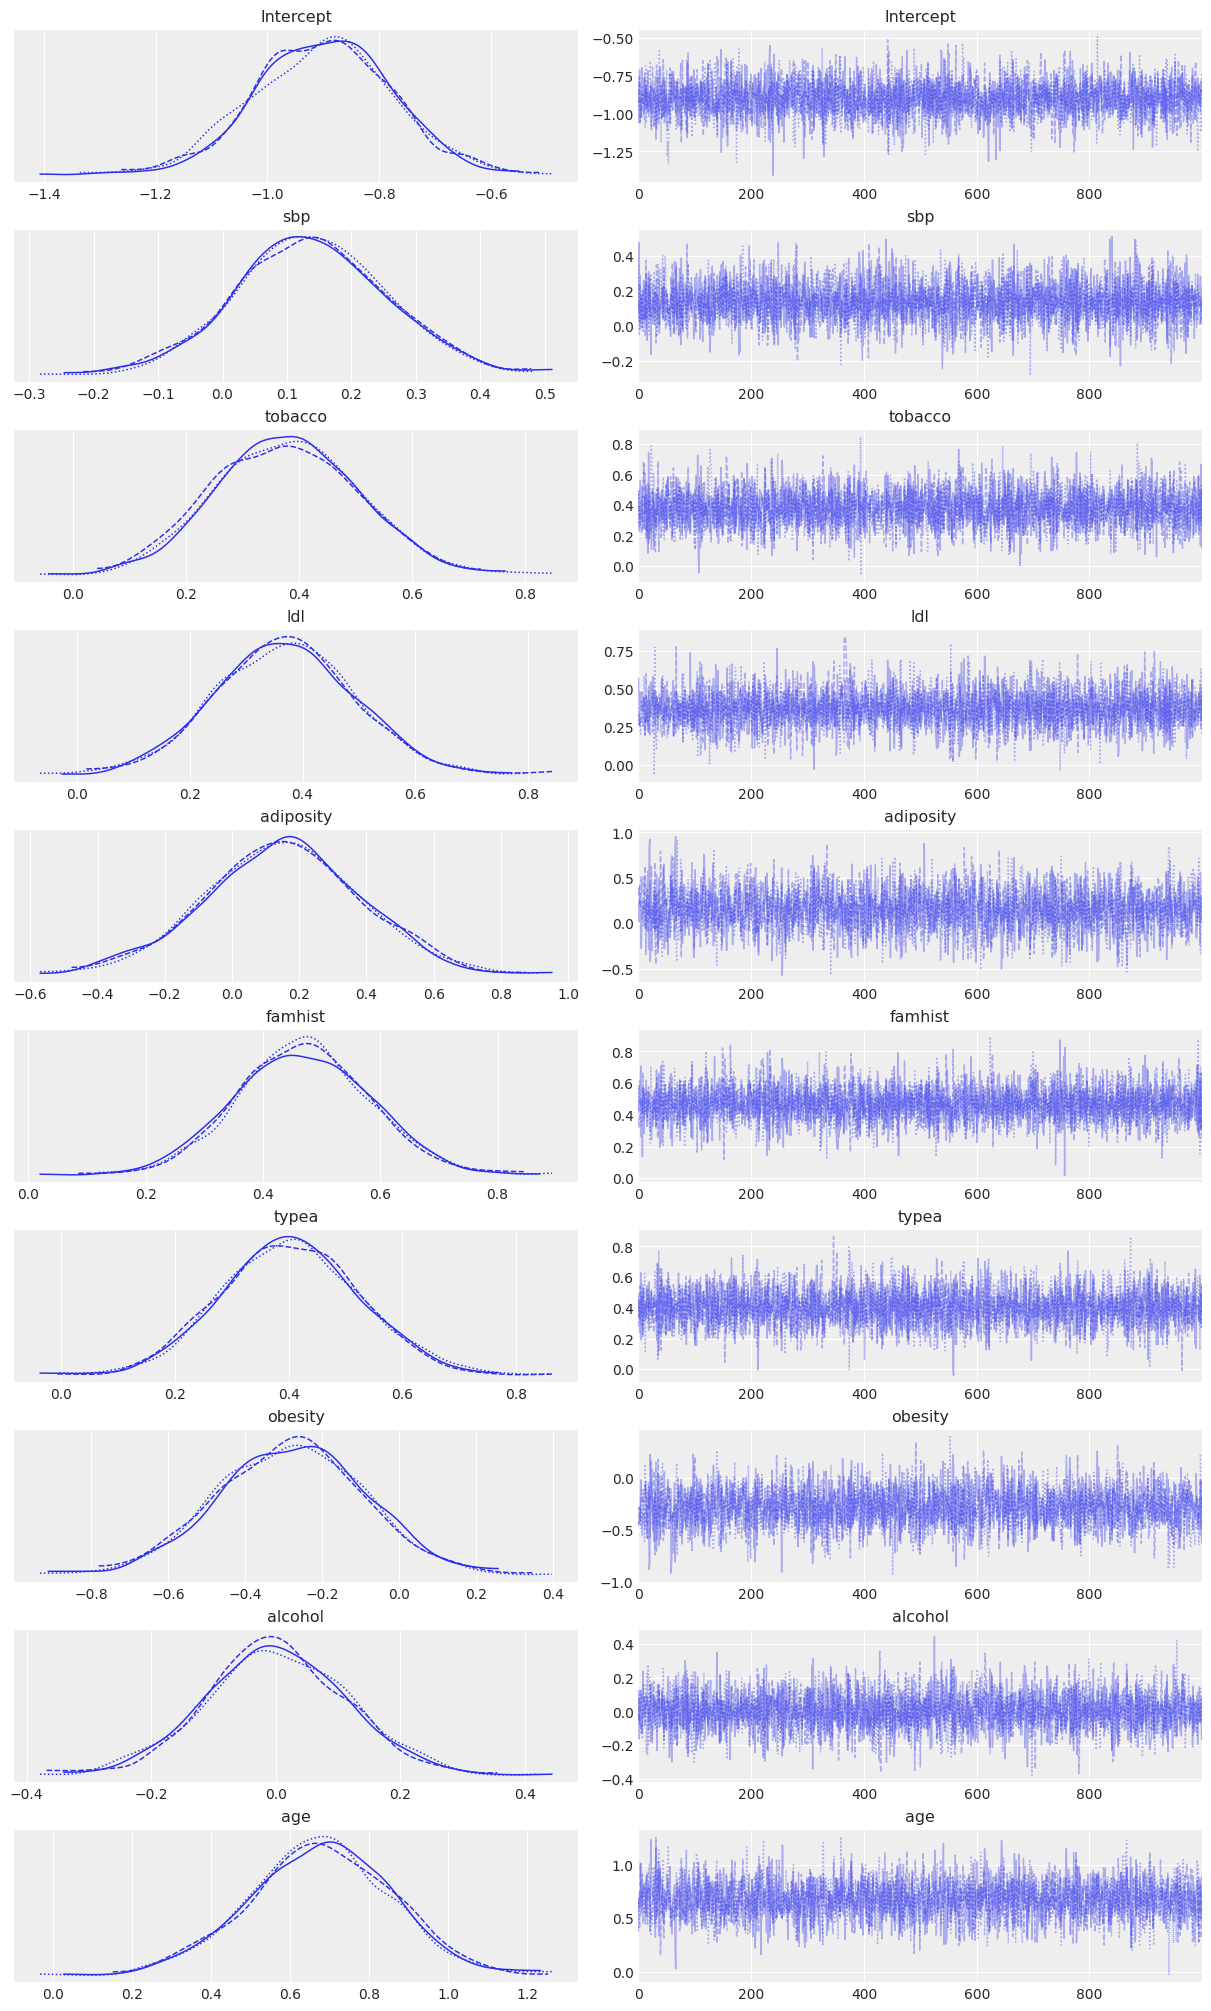

In [114]:
with model:
    pm.traceplot(trace)

<ipython-input-115-50cf5610f591>:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.plots.forestplot(trace, figsize=(12, 5))
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


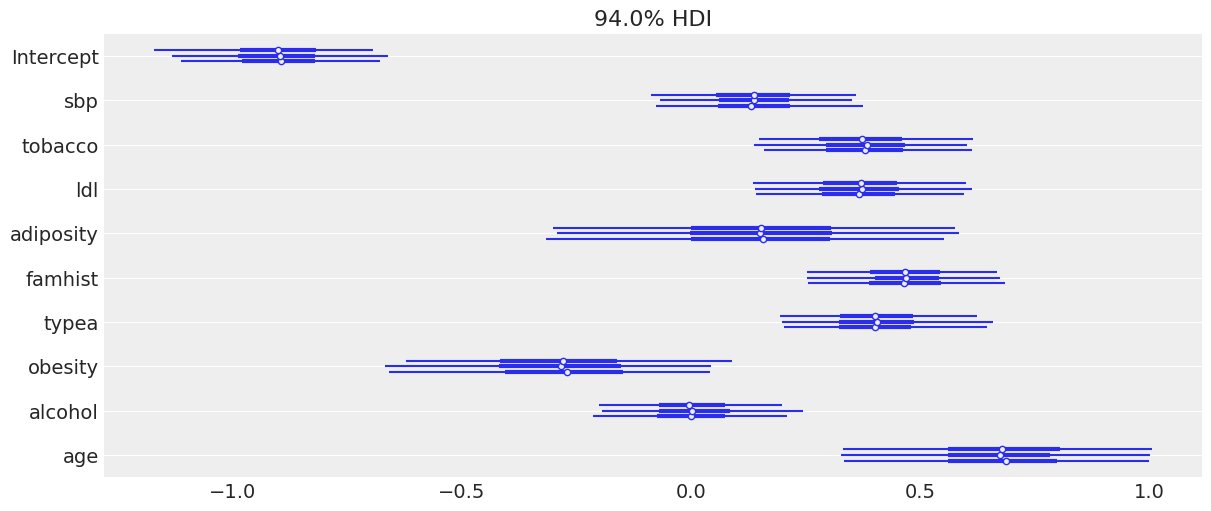

In [115]:
pm.plots.forestplot(trace, figsize=(12, 5))
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
plt.grid()  # add a grid to the plot

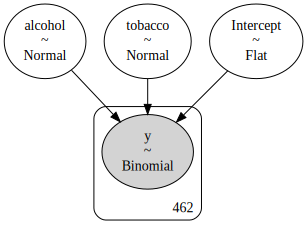

In [116]:
## Model 2

with pm.Model() as model2:
    pm.glm.GLM.from_formula(formula = 'chd ~ tobacco + alcohol', 
                            data = df_norm, 
                            family = pm.glm.families.Binomial())
pm.model_to_graphviz(model2)



In [117]:
with model2:
    trace2 = pm.sample(1000)
    model_idata2 = az.from_pymc3(trace2)
az.summary(model_idata2, round_to=2)

<ipython-input-117-4204d21cf223>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace2 = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [alcohol, tobacco, Intercept]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 445 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.66,0.10,-0.86,-0.48,0.0,0.0,3231.23,2204.22,1.0
tobacco,0.68,0.12,0.44,0.89,0.0,0.0,3632.47,2480.60,1.0
alcohol,-0.00,0.11,-0.22,0.19,0.0,0.0,3619.63,2300.74,1.0


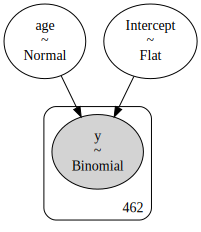

In [118]:
## Model 3

with pm.Model() as model3:
    pm.glm.GLM.from_formula(formula = 'chd ~ age', 
                            data = df_norm, 
                            family = pm.glm.families.Binomial())
pm.model_to_graphviz(model3)

In [119]:
with model3:
    trace3 = pm.sample(1000)
    model_idata3 = az.from_pymc3(trace3)
az.summary(model_idata3, round_to=2)

<ipython-input-119-902cbec4b03a>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace3 = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [age, Intercept]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 702 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.78,0.11,-0.99,-0.57,0.0,0.0,2307.28,2039.43,1.0
age,0.95,0.13,0.71,1.18,0.0,0.0,2243.91,2064.36,1.0


In [120]:
# WAIC for models
with model:
    waic_l = az.waic(trace)
waic_l

with model2:
    waic_2 = az.waic(trace2)
waic_2

with model3:
    waic_3 = az.waic(trace3)
waic_3

# Model comparisons with WAIC and weights

cmp_df = az.compare({'model1':trace, 'model2':trace2, "model3":trace3}, ic = 'WAIC',
                    method='BB-pseudo-BMA')
cmp_df

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be depre

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model1,0,-246.458519,10.348883,0.000000,0.991803,11.111906,0.000000,False,log
model3,1,-264.787936,1.942830,18.329416,0.008191,8.498085,7.334799,False,log
model2,2,-280.559857,3.296463,34.101338,0.000005,8.849542,8.818455,False,log


In [121]:
## Traceplot tells you whether random numbers are truly random or not

In [122]:
# Computing predictions by combining the models using the WAIC weights

#np.exp(-0.5*waic_p[0])/(np.exp(-0.5*waic_l[0]) + np.exp(-0.5*waic_p[0]))
# or use the value given in the table
w1 = cmp_df.loc['model1','weight']
w2 = cmp_df.loc['model2','weight']
w3 = cmp_df.loc['model3','weight']
# = .5
weights = [w, w2, w3]
weights

[0.9850179792922383, 5.054317284962122e-06, 0.008191462164062094]

In [123]:
# Bayesian model averaging 

y_bma = pm.sample_posterior_predictive_w(traces = [trace, trace2, trace3],
                                        samples=1000,
                                        models=[model, model2, model3],
                                        weights=weights)

In [124]:
#  model1

y_1 = pm.sample_posterior_predictive_w(traces = [trace],
                                        samples=1000,
                                        models=[ model])

In [125]:
#  model2

y_2 = pm.sample_posterior_predictive_w(traces = [trace2],
                                        samples=1000,
                                        models=[ model2])

In [126]:
#  model3

y_3 = pm.sample_posterior_predictive_w(traces = [trace3],
                                        samples=1000,
                                        models=[ model3])

In [127]:
y_bma["y"]

array([[1, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 1, 0]])

<AxesSubplot:>

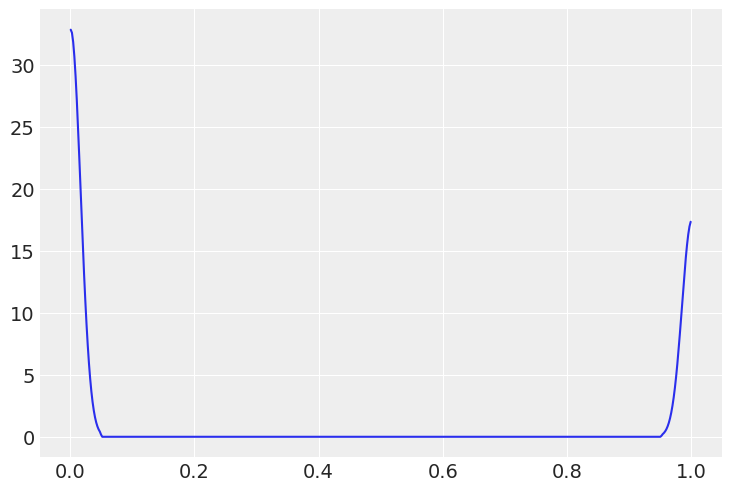

In [128]:
# Comparing average of the predictions

az.plot_kde(y_bma['y'])

<AxesSubplot:>

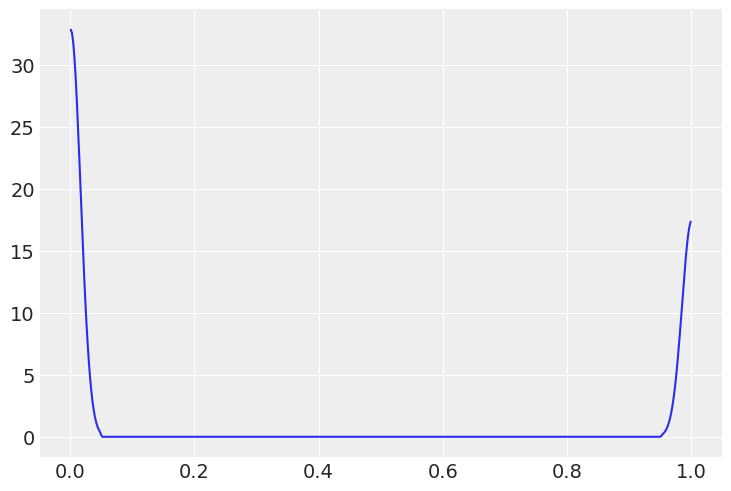

In [129]:
az.plot_kde(y_1['y'])

<AxesSubplot:>

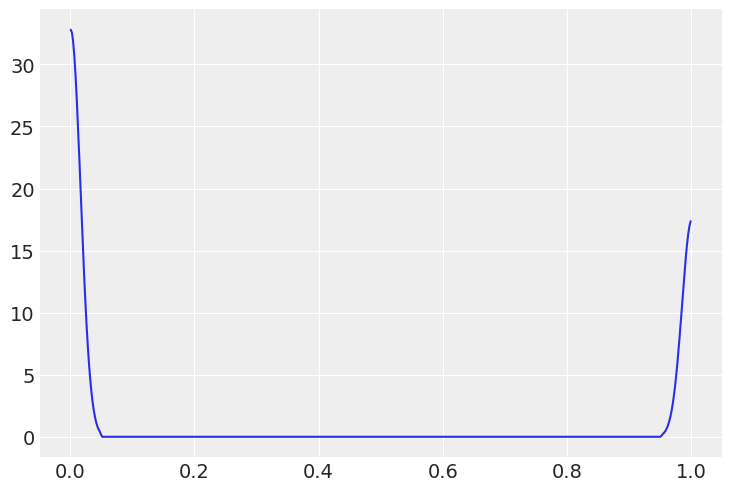

In [130]:
az.plot_kde(y_2['y'])

<AxesSubplot:>

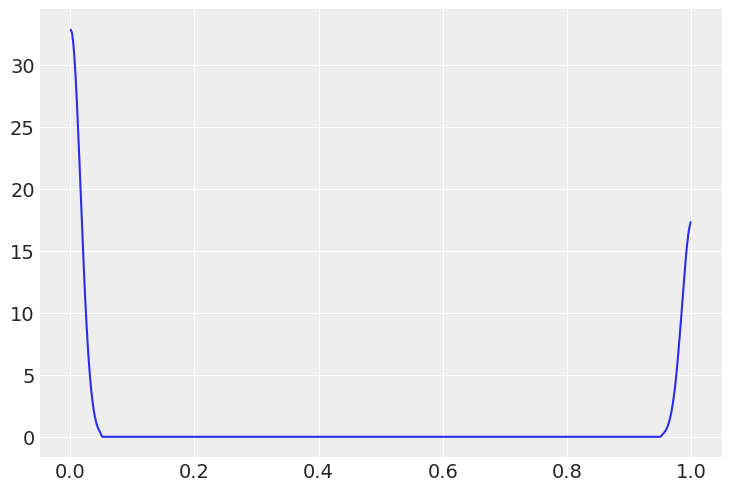

In [131]:
az.plot_kde(y_3['y'])